## Investigating Recent Trends on Thermoelectric Publications (1998-2017)

This is an IPhython version of the original work done on Databricks (see http://www.yufeil.com/tedatabricksnotebook.html for the notebook). This version is more concise.

**About Thermoelectrics**: The thermoelectric (TE) effect is the direct conversion between thermal and electrical energy. TE materials provide a clean, safe and stable way to generate power from waster heat.

**Motivation**: as a Ph.D student working on TE, I think it would be very helpful to study the recent publications on thermoelectric research. Not only can it be a review to conclude the past years, but more importantly, it provides insight into the possible future of the TE community, e.g., which materials are getting more popular, which countries will have the most researches and publications.

**Data Source**: Elsevier Scopus API. I collected ~70k papers since 1998, preprocessed them before saving into a PostgreSQL database, and then uploaded the csv files to AWS S3.

<h3 style="color:darkred">Load the data</h3>

In [92]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [168]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist

In [2]:
os.chdir("../raw_data/")

In [3]:
os.listdir()

['affiliations.csv',
 'articles.csv',
 'article_author_pairs.csv',
 'authors.csv',
 'journals.csv']

There are five data tables:

(1) **affiliations**:         stores information of instituitions, such as universities and national labs.

(2) **articles**:             stores the published papers, with its id, title, journal, date of publishing, and citation counts.

(3) **article_author_pairs**: stores the authors in a specific paper.

(4) **authors**:              stores information of authors worked on TE.

(5) **journals**:             stores the journals that publish the papers.

Load the data

In [10]:
affiliations = pd.read_csv('affiliations.csv', header=0)
affiliations.head(1)

,affiliation_id,href,affilname,city,country
0,60075528,https://api.elsevier.com/content/affiliation/a...,Siberian State Aerospace University,Krasnoyarsk,Russian Federation


In [11]:
articles = pd.read_csv('articles.csv', header=0, sep='|')
articles.head(1)

,identifier,eid,doi,title,journal,cover_date,citedby_count,preview_url,abstract
0,SCOPUS_ID:84994316286,2-s2.0-84994316286,10.3390/e18100353,Generalized thermodynamic optimization for iro...,Entropy,2016-01-01,19,https://www.scopus.com/inward/record.uri?partn...,NaN


In [14]:
article_author_pairs = pd.read_csv('article_author_pairs.csv', header=0)
article_author_pairs.head(3)

,article,author,seq
0,SCOPUS_ID:84991467035,57191536746,1
1,SCOPUS_ID:84991467035,55768024900,2
2,SCOPUS_ID:84991467035,7102729654,3


In [15]:
authors = pd.read_csv('authors.csv', header=0)
authors.head(1)

,author_id,initials,indexed_name,surname,given_name,author_url,affiliation
0,57191536746,V.I.,NaN,Zakomirnyi,Vadim I.,https://api.elsevier.com/content/author/author...,{60075346}


In [16]:
journals = pd.read_csv('journals.csv', header=0)
journals.head(1)

,journal_id,journal_name
0,1,Journal of Quantitative Spectroscopy and Radia...


<h3 style="color:darkred">Analysis</h3>

<p style="color:darkblue;font-size:1.2em">(1) Number of TE publications each year</p>

In [27]:
articles['year'] = articles['cover_date'].apply(lambda x: x[:4])
articles_98_16 = articles[(articles['year']>'1997')&(articles['year']<'2017')]

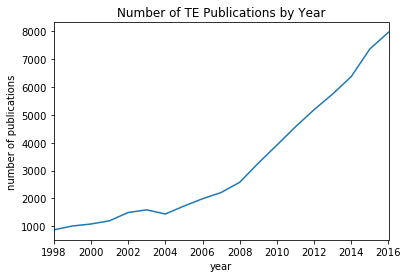

In [28]:
g_year = articles_98_16.groupby('year')
ax = g_year['title'].count().plot()
ax.set_ylabel('number of publications')
ax.set_title('Number of TE Publications by Year')

The TE publications are steadily increasing

<p style="color:darkblue;font-size:1.2em">(2) What journals are popular?</p>

In [39]:
# Number of TE papers published by journal each year
journal_papers_count = articles_98_16.pivot_table(values='title',index='journal',columns='year',aggfunc=len)
journal_papers_count.dropna(axis=0,thresh=10,inplace=True)
journal_papers_count.head(3)

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
journal,,,,,,,,,,,,,,,,,,,
AIP Conference Proceedings,NaN,NaN,NaN,2.0,NaN,NaN,NaN,27.0,41.0,35.0,28.0,18.0,20.0,49.0,156.0,56.0,24.0,12.0,63.0
Acta Materialia,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,5.0,14.0,8.0,18.0,18.0,22.0,27.0,20.0,34.0,27.0,27.0
Acta Physica Polonica A,2.0,NaN,4.0,2.0,1.0,3.0,NaN,3.0,NaN,2.0,10.0,7.0,8.0,10.0,16.0,8.0,12.0,13.0,11.0


In [40]:
# Average citations of TE papers published by journal each year
journal_papers_citation = articles_98_16.pivot_table(values='citedby_count',index='journal',columns='year',aggfunc=np.mean)
journal_papers_citation.dropna(axis=0,thresh=10,inplace=True)
journal_papers_citation.head(3)

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
journal,,,,,,,,,,,,,,,,,,,
AIP Conference Proceedings,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.925926,2.512195,3.057143,1.964286,0.500000,1.600000,0.714286,1.160256,0.839286,1.583333,0.833333,0.206349
Acta Materialia,103.5,33.0,156.666667,116.0,34.0,45.000000,50.0,12.000000,36.800000,46.285714,49.250000,59.611111,30.166667,27.318182,18.962963,18.050000,19.705882,14.666667,5.185185
Acta Physica Polonica A,13.0,NaN,2.500000,3.5,2.0,3.333333,NaN,25.000000,NaN,3.000000,2.300000,4.571429,4.625000,4.200000,2.000000,2.250000,1.666667,0.307692,0.545455


I plotted them in Tableau

<img src="https://s3.amazonaws.com/thermoelectric-publication-s3/MostPopularJournals.png" alt="Most Popular Journals">

<img src="https://s3.amazonaws.com/thermoelectric-publication-s3/MostSignificantJournals.png" alt="Most Significant Journals">

One thing to note is that the papers in some journals/magazines, such as Science and Nature, are not recorded in Elsevier Scopus API. But still, it is not a surprise that Rev. Mod. Phys. and some Nature magazines are among the most significant list.

I also extended the top list to Top30 and check which journals are both popular and significant for thermoelectric papers. Only 3 of them are qualified: Nano Letters, Physical Review Letters, and Advanced Materials. These are all good journals and it is also not that difficult (comparing with Nature, Rev. Mod. Phys., etc.) to get your thermoelectric papers published on them

Here is the plot of the TE publication trend on some high impact factor journals.

<img src="https://s3.amazonaws.com/thermoelectric-publication-s3/PublicationTrendOnHighIFJournals.png" alt="Publication Trend by Journal">

<p style="color:darkblue;font-size:1.2em">(3) Distribution of authors</p>

In [49]:
# Join articles and authors
detailedArticles = article_author_pairs.join(authors, lsuffix='author',rsuffix='author_id')
detailedArticles = detailedArticles.join(articles, lsuffix='article',rsuffix='identifier')

# Some authors are associated with several affiliations. For simplicity, we only consider the first affiliation
detailedArticles = detailedArticles[detailedArticles['affiliation'].notnull()]
detailedArticles['affiliation'] = detailedArticles['affiliation'].[apply(lambda x: x.lstrip('{').rstrip('}').split(',')[0])

# Join affiliation to detailedArticles
detailedArticles = detailedArticles.join(affiliations, lsuffix='affiliation',rsuffix='affiliation_id')

detailedArticles.head(3)

,article,author,seq,author_id,initials,indexed_name,surname,given_name,author_url,affiliation,...,cover_date,citedby_count,preview_url,abstract,year,affiliation_id,href,affilname,city,country
0,SCOPUS_ID:84991467035,57191536746,1,5.719154e+10,V.I.,NaN,Zakomirnyi,Vadim I.,https://api.elsevier.com/content/author/author...,60075346,...,2016-01-01,19.0,https://www.scopus.com/inward/record.uri?partn...,NaN,2016,60075528.0,https://api.elsevier.com/content/affiliation/a...,Siberian State Aerospace University,Krasnoyarsk,Russian Federation
1,SCOPUS_ID:84991467035,55768024900,2,5.576802e+10,I.L.,NaN,Rasskazov,Ilia L.,https://api.elsevier.com/content/author/author...,60075346,...,2016-10-28,2.0,https://www.scopus.com/inward/record.uri?partn...,NaN,2016,60015749.0,https://api.elsevier.com/content/affiliation/a...,"Kirensky Institute of Physics, Siberian Branch...",Krasnoyarsk,Russian Federation
2,SCOPUS_ID:84991467035,7102729654,3,7.102730e+09,S.V.,NaN,Karpov,Sergey V.,https://api.elsevier.com/content/author/author...,60075346,...,2016-06-30,3.0,https://www.scopus.com/inward/record.uri?partn...,NaN,2016,60075346.0,https://api.elsevier.com/content/affiliation/a...,Siberian Federal University,Krasnoyarsk,Russian Federation


In [88]:
# Select authors that have published at least 3 TE papers
authors_filtered = detailedArticles.groupby('author').count()['article']

authors_filtered = authors_filtered[authors_filtered >= 3].reset_index()

authors_affi = authors[authors['affiliation'].notnull()]
authors_affi['affiliation'] = authors_affi['affiliation'].apply(lambda x: x.lstrip('{').rstrip('}').split(',')[0])
authors_affi = authors_affi.join(affiliations, lsuffix='affiliation',rsuffix='affiliation_id')

authors_by_country = authors_affi[authors_affi['author_id'].isin(authors_filtered['author'])]
authors_by_country = authors_by_country.groupby('country')['author_id'].count().reset_index()
authors_by_country.columns = ['Country','Number of Authors']
authors_by_country.sort_values('Number of Authors',ascending=False)[:10]

,Country,Number of Authors
17,China,506
103,United States,501
37,India,322
44,Japan,273
33,Germany,197
31,France,190
81,Russian Federation,151
90,South Korea,106
43,Italy,85
102,United Kingdom,75


In [79]:
authors_by_country.to_csv('analyzed/authors_by_country.csv',index=True)

With this table, we can plot the distribution of authors in each country. I only selected the authors that have published at least 3 TE papers, and plotted it in Tableau

<img src="https://s3.amazonaws.com/thermoelectric-publication-s3/AuthorMap.png" alt="Author Map">

And we can plot number of publications by country each year.

<img src="https://s3.amazonaws.com/thermoelectric-publication-s3/PublicationByCountry1998-2016.png" alt="Publications By Country">

So since 2012, China has published more thermoelectric papers than United States during one year. Thermoelectricity now attracts more and more interests in developing countries. 

<p style="color:darkblue;font-size:1.2em">(4) Analysis based on the titles of the papers.</p>

In this section we work on the titles of the articles.

In [96]:
titles = articles[['title', 'year', 'citedby_count']]
titles = titles[pd.notnull(titles['title'])]
titles.head()

,title,year,citedby_count
0,Generalized thermodynamic optimization for iro...,2016,19
1,First-principles study of the defected phospho...,2016,2
2,Interactions and thermoelectric effects in a p...,2016,3
3,Effect of sample producing conditions on the t...,2003,40
4,Temperature mapping of operating nanoscale dev...,2016,14


In [97]:
titles.shape

(72864, 3)

In [98]:
# 1. Clean the title
def title_cleanse(title):
    """
        Some titles contain molecular formula, and needs to be cleaned, for instance:
        'properties of Mg<inf>2</inf>Ge<inf>x</inf>Sn<inf>1-x</inf> (x = 0.25, 0.50, 0.75) '
        'SrTiO3/SrTi1 ?' &lt;i&gt;x&lt;/i&gt;Fe&lt;i&gt;x&lt;/i&gt;O3 '
        'Bi&lt;inf&gt;2-x&lt;/inf&gt;Sb&lt;inf&gt;x&lt;/inf&gt;Te&lt;inf&gt;3-y&lt;/inf&gt;Se&lt;inf&gt;y&lt;/inf&gt;:'
    """
    replace_list = [r'<inf>', r'</inf>', r'&lt;inf&gt;', r'&lt;/inf&gt;', r'?', r'<sup>', r'</sup>']
        
    for rep in replace_list:
        title = title.replace(rep, '')
        
    # Some titles still have question mark '?' left, and in most cases they represent dash '-'.
    title=title.replace(r'?',r'-')
    
    return title

# 2. Remove compositions in the molecular formula. For example, Bi2Te3 becomes BiTe. 
#    The purpose is to make the analysis easier. Also, it makes sense in most cases
#    that the compounds consisting of same elements are related to each other, even 
#    they have different compositions.
def extract_compounds(title):
    # Extract compounds from a title.
    ele='(A[cglmrstu]|B[aehikr]?|C[adeflmnorsu]?|D[bsy]|E[rsu]|F[elmr]?|G[ade]|H[efgos]?|I[nr]?|Kr?|L[airuv]|M[dgnot]|N[abdeiop]?|Os?|P[abdmortu]?|R[abefghnu]|S[bcegimnr]?|T[abcehilm]|U(u[opst])?|V|W|Xe|Yb?|Z[nr])'
    pattern=r'(('+ele+'+(\d+(\.\d+)?\-?)?([xyz]|((\d\.)?\d))?(\-\d+(\.\d+)?)?)+)[^a-zA-Z0-9]'
    
    match = re.findall(pattern, title+" ")
    compounds = [m[0] for m in match] if match else []
    
    # To-do: convert compound name to formula. Maybe can use ChemSpider or PubChem API.
    
    return compounds

def remove_composition(title):
    # Remove the compositions in the molecular formula: Bi2Te3 becomes BiTe
    compounds = extract_compounds(title)
    if compounds:
        for compound in compounds:
            new_compound = re.sub(r'[\dxyz\.?\-]', '', compound)
            title = title.replace(compound, new_compound)
    return title

# 3. Extract chemical compounds from the title
def extract_compounds_return_string(title):
    compounds = extract_compounds(title)
    new_compounds = []
    
    for compound in compounds:
        new_compounds.append(re.sub(r'[\dxyz\.?\-]', '', compound))
        
    return ",".join(new_compounds)

Let's clean the title and create a 'compounds' column.

In [99]:
titles['cleaned_title'] = titles['title'].apply(title_cleanse)

In [104]:
titles['compounds'] = titles['cleaned_title'].apply(extract_compounds_return_string)

In [102]:
titles['cleaned_title'] = titles['cleaned_title'].apply(remove_composition)

In [112]:
titles[titles['compounds'] != ''].head()

,title,year,citedby_count,cleaned_title,compounds
3,Effect of sample producing conditions on the t...,2003,40,Effect of sample producing conditions on the t...,ZnS
5,The effect of mesoporous structure on the ther...,2016,1,The effect of mesoporous structure on the ther...,"La,SrTiO"
7,Synthesis of Ge/Si core/shell nanowires with s...,2016,0,Synthesis of Ge/Si core/shell nanowires with s...,"Ge,Si"
14,Effect of a High Density of Stacking Faults on...,2016,10,Effect of a High Density of Stacking Faults on...,GaAs
16,First principles calculation of thermoelectric...,2016,1,First principles calculation of thermoelectric...,BN


Now we have cleaned titles, and the compounds that were worked on. The first thing we can do is to study what materials/compounds are popular.

In [147]:
column_names = ['compound','year','citeby_count']
compoundsDF = pd.DataFrame(columns=column_names)

def get_compounds_info(titles):
    # For each row in titles, we extract the compounds studied, and add it to compoundsDF.
    for i in titles.index:
        compounds = titles.loc[i,'compounds'].split(',')
        year, citedby_count = titles.loc[i,'year'],titles.loc[i,'citedby_count']
        for compound in compounds:
            if len(compound) > 0:
                compoundsDF.loc[compoundsDF.shape[0]] = [compound,year,citedby_count]

In [148]:
# Create compoundsDF
get_compounds_info(titles)

In [162]:
compoundsDF_filtered = compoundsDF[(compoundsDF['year']>'1997')]
compoundsDF_filtered = compoundsDF_filtered[compoundsDF_filtered['compound'].apply(lambda x: len(x) >= 3)]
compoundsDF_filtered.shape

(27556, 3)

In [163]:
compounds_by_year = compoundsDF_filtered[['compound','year']].pivot_table(index='compound', columns='year', aggfunc=len)
compounds_by_year.head()

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
compound,,,,,,,,,,,,,,,,,,,,
AgAlO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
AgAuS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
AgAuSe,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
AgAuTe,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
AgBi,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN


Plot compounds studied each year in Tableau:

<img src="https://s3.amazonaws.com/thermoelectric-publication-s3/ThermoelectricMaterialsTrend.png" alt="Thermoelectric Materials Trend">

(1) Bismuth telluride is still the most popular thermoelectric materials these years. Note that here BiSbTe and BiSeTe are not included, even though they both belong to Bi2Te3 family. 

(2) PbTe was intensively studied early 2010s, but gets less attention in recent years. 

(3) SnSe now attracts more and more interest. This is largely due to a Nature paper published in 2014, where the figure of merit was record-high. (Nature 508, 373 (2014))

<p style="color:darkblue;font-size:1.2em">(5) Extract key words each year</p>

We implement NLTK to analyze the key words each year. And we will generate wordclouds.

Firstly, we adopt TF-IDF, to evaluate the importance of each word for each year.

In [172]:
# Pre-process the titles: stop words, lemmatize
import string

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def process_title(title):
    words = word_tokenize(title)
    try:
        words[0] = words[0].lower()
    except Excetion as e:
        pass
    words = [lemmatizer.lemmatize(w.translate(string.punctuation)) for w in words if not w in stop_words and len(w)>3]
    
    return ' '.join(words)+','

titles['processed_title'] = titles['cleaned_title'].apply(process_title)

In [176]:
# Attach the extracted compounds to the title to strengthen the importance of materials.
titles['processed_title']=titles['processed_title']+titles['compounds'].apply(lambda x: ' '.join(x.split(',')))

Now analyze popular words each year.

In [186]:
wordsByYear = titles.groupby('year')['processed_title'].apply(lambda x: "{}".format(','.join(x)))
wordsByYearDF = wordsByYear.reset_index(level=0)
wordsByYearDF = wordsByYearDF[(wordsByYearDF['year']>'1997')]
wordsByYearDF.head(3)

,year,processed_title
8,1998,environmental issue arising thermopower genera...
9,1999,InitioDetermination Novel Perovskite-Related S...
10,2000,study bismuth sulphoselenide thin film Growth ...


In [188]:
# We use TF-IDF to get the relative importance of each word over years.
from sklearn.feature_extraction.text import TfidfVectorizer

# Build [words] for all years
words_list_all_years = wordsByYearDF['processed_title'].tolist()

# Build tfidf model, and fit the words_list_all_years
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.7, stop_words='english', lowercase=False)
tfidf = vectorizer.fit_transform(words_list_all_years)

# tfidf stores the TFIDF vectors each year.
tfidf = tfidf.toarray()

feature_names = vectorizer.get_feature_names()
vocabulary = vectorizer.vocabulary_

column_names = [''] * len(vocabulary)

for key, value in vocabulary.items():
    column_names[value] = key

In [193]:
tfidf_df = pd.DataFrame(tfidf, columns=column_names)
tfidf_df['year'] = [i for i in range(1998,2018)]

In [194]:
# Retrieve top words each year, and stores in topWordsByYearTFIDF
topWordsByYearTFIDF = {}

for i in range(tfidf_df.shape[0]):
    key = int(tfidf_df.loc[i, 'year'])
    
    word_score_list = []
    
    for j in range(tfidf_df.shape[1]-1):
        word_score_list.append((tfidf_df.iloc[i,j], column_names[j]))
    
    topWordsByYearTFIDF[key] = sorted(word_score_list,reverse=True)

Generate Word Cloud Each Year

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

for year in range(1998, 2018):
    print("Generating WordCloud for year {}".format(year))
    d = {}
    for c, w in topWordsByYearTFIDF[year]:
        if w[0] != 'x' and not w[0].isdigit():
            d[w] = c
    
    for y in range(1998, 2018):
        d[str(y)] = 0
    d[str(year)] = topWordsByYearTFIDF[year][0][0]
    
    mask = np.array(Image.open('analyzed/popular_words/mask.png'))
    
    stopwords = set(STOPWORDS)
    stopwords.add("using")
    stopwords.add("yesterday")
    
    wordcloud = WordCloud(background_color="white", mask=mask, stopwords=stopwords)
    wordcloud.generate_from_frequencies(frequencies=d)
    wordcloud.to_file('analyzed/popular_words/wordcloud_{}.png'.format(year))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Here are the plots:

<img src="https://s3.amazonaws.com/thermoelectric-publication-s3/wordcloudeachyear/KeywordsPerYear.png" alt="Keywords Per Year">